In [3]:
!pip install --quiet pycocotools ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.1 MB/s eta 0:00:00:00:0100:01


In [ ]:
!pip install pascal-voc2coco

In [38]:
import os
import torch
import random
import json
import glob

import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
import matplotlib.patches as patches

from scipy.optimize import linear_sum_assignment
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pathlib import Path
from collections import defaultdict
from torchvision.ops import box_iou
from tqdm import tqdm
from pascal_voc2coco import convert

In [5]:
# Data Paths
COCO_ROOT = "/kaggle/input/coco-2017-dataset/coco2017"
VAL_IMAGES = os.path.join(COCO_ROOT, "val2017")
ANNOT_PATH = os.path.join(COCO_ROOT, "annotations/instances_val2017.json")
OUTPUT_DIR = "/kaggle/working/yolo11_inference"
PRED_DIR = Path("/kaggle/working/yolo11_inference/val2017_preds/labels")
OUTPUT_JSON = "/kaggle/working/yolo11_preds.json"

In [ ]:
# VOC2012 paths
ann_dir = '/kaggle/input/pascal-voc-2012/VOC2012/Annotations'
# Collect all JPEG filenames
img_dir = '/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages'
output_json = '/kaggle/working/voc2012_all_as_coco.json'

# Prepare list of annotation filenames without extension
xml_files = sorted(glob.glob(os.path.join(ann_dir, "*.xml")))
basename_list = [os.path.splitext(os.path.basename(x))[0] for x in xml_files]

# Save a temporary txt file with all image basenames
split_txt = '/kaggle/working/voc2012_split.txt'
with open(split_txt, 'w') as f:
    for name in basename_list:
        f.write(f"{name}\n")

# Now convert
convert(ann_dir, split_txt, output_json)
print(f"COCO JSON written to {output_json}")

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load a COCO-pretrained YOLO11x model
model = YOLO("yolo11x.pt")
model.to(device)  # move model to GPU

100%|██████████| 109M/109M [00:00<00:00, 259MB/s] 


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(384, eps=0.001, momentum=0.03, affine=True, track_

In [7]:
# Run inference
results = model.predict(
    source=VAL_IMAGES,      # folder of COCO val images
    save=True,              # save annotated images
    save_txt=True,          # save raw predictions (.txt per image)
    save_conf=True,         # save confidence in the .txt files
    project=OUTPUT_DIR,     # outputs go to /kaggle/working/yolov8_inference
    name="val2017_preds",   # subfolder name
    imgsz=640,              # inference size in pixels
    conf=0.25,             # confidence threshold
    batch=16                # process 16 images at once
)

print("Done – check:", os.path.join(OUTPUT_DIR, "val2017_preds"))


image 1/5000 /kaggle/input/coco-2017-dataset/coco2017/val2017/000000000139.jpg: 640x640 1 person, 3 chairs, 2 potted plants, 2 dining tables, 2 tvs, 1 refrigerator, 5 vases, 29.3ms
image 2/5000 /kaggle/input/coco-2017-dataset/coco2017/val2017/000000000285.jpg: 640x640 1 bear, 29.3ms
image 3/5000 /kaggle/input/coco-2017-dataset/coco2017/val2017/000000000632.jpg: 640x640 1 bottle, 1 chair, 2 potted plants, 1 bed, 3 books, 29.3ms
image 4/5000 /kaggle/input/coco-2017-dataset/coco2017/val2017/000000000724.jpg: 640x640 2 stop signs, 29.3ms
image 5/5000 /kaggle/input/coco-2017-dataset/coco2017/val2017/000000000776.jpg: 640x640 1 couch, 3 teddy bears, 29.3ms
image 6/5000 /kaggle/input/coco-2017-dataset/coco2017/val2017/000000000785.jpg: 640x640 1 person, 1 skis, 29.3ms
image 7/5000 /kaggle/input/coco-2017-dataset/coco2017/val2017/000000000802.jpg: 640x640 1 oven, 1 refrigerator, 29.3ms
image 8/5000 /kaggle/input/coco-2017-dataset/coco2017/val2017/000000000872.jpg: 640x640 2 persons, 1 sports 

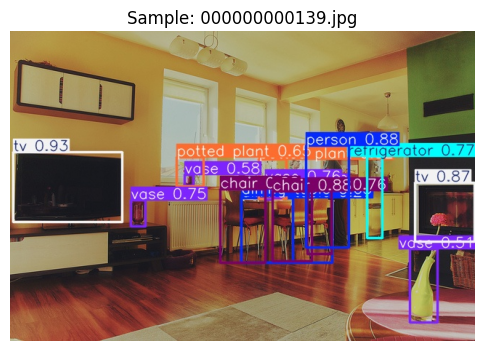

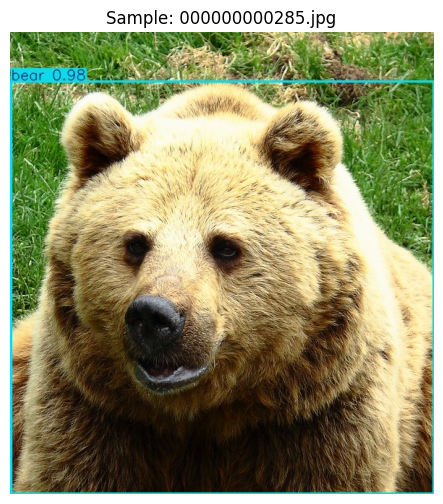

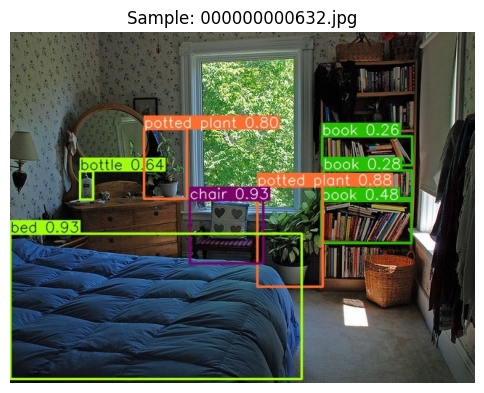

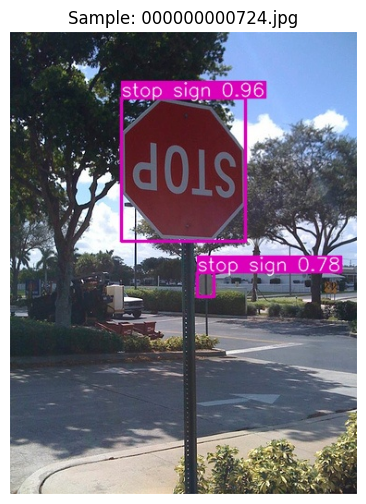

In [8]:
img_dir = "/kaggle/working/yolo11_inference/val2017_preds"

# Pick the first 4 images
files = sorted([f for f in os.listdir(img_dir) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))])[:4]

# Display each as its own figure
for fname in files:
    img_path = os.path.join(img_dir, fname)
    img = Image.open(img_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Sample: {fname}")
    plt.show()

In [9]:
# Load COCO ground truth
coco_gt = COCO(ANNOT_PATH)
img_ids = coco_gt.getImgIds()

loading annotations into memory...
Done (t=1.02s)
creating index...
index created!


In [10]:
print(img_ids[:5])
print(len(img_ids))

[397133, 37777, 252219, 87038, 174482]
5000


In [11]:
COCO80_CATEGORY_IDS = [
    1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
    11, 13, 14, 15, 16, 17, 18, 19, 20, 21,
    22, 23, 24, 25, 27, 28, 31, 32, 33, 34,
    35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
    46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
    56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
    67, 70, 72, 73, 74, 75, 76, 77, 78, 79,
    80, 81, 82, 84, 85, 86, 87, 88, 89, 90
]

In [12]:
# Parse per-image .txt files
coco_results = []
for img_id in tqdm(img_ids, desc="Converting txt→JSON"):
    info = coco_gt.loadImgs(img_id)[0]
    txt_file = PRED_DIR / info['file_name'].replace(".jpg", ".txt")
    if not txt_file.exists():
        continue
    W, H = info['width'], info['height']
    with open(txt_file) as f:
        for line in f:
            cls, x_c, y_c, w, h, conf = map(float, line.split())
            # convert normalized center‐format to [x,y,width,height]
            x1 = (x_c - w/2) * W
            y1 = (y_c - h/2) * H
            bbox = [x1, y1, w * W, h * H]
            coco_results.append({
                "image_id": img_id,
                "category_id": COCO80_CATEGORY_IDS[int(cls)],
                "bbox": bbox,
                "score": conf
            })

Converting txt→JSON: 100%|██████████| 5000/5000 [00:00<00:00, 14864.74it/s]


In [13]:
print(len(coco_results))
print(coco_results[:5])

34272
[{'image_id': 397133, 'category_id': 1, 'bbox': [385.0272, 69.34522699999998, 114.08, 278.628602], 'score': 0.922158}, {'image_id': 397133, 'category_id': 51, 'bbox': [30.36864, 343.26404035, 69.70752, 42.6948333], 'score': 0.869083}, {'image_id': 397133, 'category_id': 64, 'bbox': [0.10336000000000123, 0.9547720000000067, 63.202944, 149.662646], 'score': 0.860322}, {'image_id': 397133, 'category_id': 51, 'bbox': [59.156800000000004, 288.2248292, 76.11968, 39.8898276], 'score': 0.768998}, {'image_id': 397133, 'category_id': 79, 'bbox': [489.08256, 200.273675, 129.7312, 144.87597599999998], 'score': 0.751036}]


In [14]:
# Write out the JSON
with open(OUTPUT_JSON, "w") as f:
    json.dump(coco_results, f)
print(f"Saved {len(coco_results)} predictions → {OUTPUT_JSON}")

Saved 34272 predictions → /kaggle/working/yolo11_preds.json


In [15]:
# Run COCOeval
coco_dt = coco_gt.loadRes(OUTPUT_JSON)
evaluator = COCOeval(coco_gt, coco_dt, iouType='bbox')
evaluator.params.imgIds = img_ids   # evaluate on the same set
evaluator.evaluate()                # run per-image matching
evaluator.accumulate()              # accumulate stats
evaluator.summarize()               # print mAP, AP@.50, etc.

Loading and preparing results...
DONE (t=0.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=12.65s).
Accumulating evaluation results...
DONE (t=1.83s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.623
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.530
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.543
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.365
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

In [26]:
def evaluate_iou_greedy(results_json, coco_gt):
    with open(results_json, "r") as f:
        results = json.load(f)

    preds_by_image = defaultdict(list)
    for pred in results:
        preds_by_image[pred["image_id"]].append(pred)

    iou_scores = []
    image_ids = list(preds_by_image.keys())

    for image_id in image_ids:
        preds = preds_by_image[image_id]
        pred_boxes = [pred["bbox"] for pred in preds]
        if len(pred_boxes) == 0:
            continue
        pred_boxes = torch.tensor(pred_boxes, dtype=torch.float32)
        pred_boxes_xyxy = pred_boxes.clone()
        pred_boxes_xyxy[:, 2] += pred_boxes_xyxy[:, 0]
        pred_boxes_xyxy[:, 3] += pred_boxes_xyxy[:, 1]

        ann_ids = coco_gt.getAnnIds(imgIds=image_id)
        anns = coco_gt.loadAnns(ann_ids)
        gt_boxes = [ann["bbox"] for ann in anns]
        if len(gt_boxes) == 0:
            continue
        gt_boxes = torch.tensor(gt_boxes, dtype=torch.float32)
        gt_boxes_xyxy = gt_boxes.clone()
        gt_boxes_xyxy[:, 2] += gt_boxes_xyxy[:, 0]
        gt_boxes_xyxy[:, 3] += gt_boxes_xyxy[:, 1]

        ious = box_iou(gt_boxes_xyxy, pred_boxes_xyxy)
        max_ious, _ = ious.max(dim=1)
        iou_scores.extend(max_ious.cpu().numpy())
    
    mean_iou = np.mean(iou_scores) if iou_scores else 0.0
    boxes_count = len(iou_scores)
    return boxes_count, mean_iou

boxes_count, iou = evaluate_iou_greedy(OUTPUT_JSON, coco_gt)
print(f"Number of boxes: {boxes_count}")
print(f"Mean IoU = {iou:.4f}")

Number of boxes: 36763
Mean IoU = 0.6458


In [27]:
def evaluate_iou_hungarian(results_json, coco_gt):
    with open(results_json, "r") as f:
        results = json.load(f)

    preds_by_image = defaultdict(list)
    for pred in results:
        preds_by_image[pred["image_id"]].append(pred)

    iou_scores = []
    image_ids = list(preds_by_image.keys())

    for image_id in image_ids:
        preds = preds_by_image[image_id]
        pred_boxes = [pred["bbox"] for pred in preds]
        if len(pred_boxes) == 0:
            continue
        pred_boxes = torch.tensor(pred_boxes, dtype=torch.float32)
        pred_boxes_xyxy = pred_boxes.clone()
        pred_boxes_xyxy[:, 2] += pred_boxes_xyxy[:, 0]
        pred_boxes_xyxy[:, 3] += pred_boxes_xyxy[:, 1]

        ann_ids = coco_gt.getAnnIds(imgIds=image_id)
        anns = coco_gt.loadAnns(ann_ids)
        gt_boxes = [ann["bbox"] for ann in anns]
        if len(gt_boxes) == 0:
            continue
        gt_boxes = torch.tensor(gt_boxes, dtype=torch.float32)
        gt_boxes_xyxy = gt_boxes.clone()
        gt_boxes_xyxy[:, 2] += gt_boxes_xyxy[:, 0]
        gt_boxes_xyxy[:, 3] += gt_boxes_xyxy[:, 1]

        ious = box_iou(gt_boxes_xyxy, pred_boxes_xyxy).cpu().numpy()
        if ious.size == 0:
            continue

        # Hungarian matching (maximize IoU, so minimize -IoU)
        cost_matrix = -ious
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        matched_ious = ious[row_ind, col_ind]
        iou_scores.extend(matched_ious)

    mean_iou = np.mean(iou_scores) if iou_scores else 0.0
    boxes_count = len(iou_scores)
    return boxes_count, mean_iou

boxes_count, iou = evaluate_iou_hungarian(OUTPUT_JSON, coco_gt)
print(f"Number of boxes: {boxes_count}")
print(f"Mean IoU (Hungarian) = {iou:.4f}")

Number of boxes: 31196
Mean IoU (Hungarian) = 0.7346


In [53]:
def visualize_yolo_feature_maps_and_boxes(
    img_path, model, device, layer_idxs=[4, 8, 16], threshold=0.5
):
    # --- 1. Register hooks to get feature maps ---
    feature_maps = {}
    hooks = []
    def get_activation(idx):
        def hook(module, input, output):
            feature_maps[idx] = output.detach().cpu()
        return hook
    # Check YOLO model structure for your version (usually model.model.model)
    for idx in layer_idxs:
        hooks.append(model.model.model[idx].register_forward_hook(get_activation(idx)))

    # --- 2. Load and preprocess image (YOLO standard: 640x640 by default) ---
    im = Image.open(img_path).convert('RGB')
    orig_w, orig_h = im.size
    input_size = 640
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
    ])
    img_resized = transform(im).unsqueeze(0).to(device)

    # --- 3. Forward pass ---
    with torch.no_grad():
        results = model(img_resized)
    for h in hooks:
        h.remove()

    # --- 4. Extract predictions ---
    try:
        preds = results[0].boxes  # Ultralytics YOLOv8
    except AttributeError:
        preds = results[0]        # fallback for older

    boxes = preds.xyxy.cpu().numpy()        # [N, 4], x1,y1,x2,y2 IN 640x640 space
    scores = preds.conf.cpu().numpy()
    labels = preds.cls.cpu().numpy()

    # --- 5. Threshold and rescale coordinates to original image ---
    mask = scores >= threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    # Scale boxes to original image size
    scale_w = orig_w / input_size
    scale_h = orig_h / input_size
    boxes_scaled = boxes.copy()
    boxes_scaled[:, [0, 2]] *= scale_w
    boxes_scaled[:, [1, 3]] *= scale_h

    # --- 6. Plot feature maps from selected layers ---
    plt.figure(figsize=(len(layer_idxs) * 5, 4))
    for i, idx in enumerate(layer_idxs):
        fmap = feature_maps[idx][0]          # [C, H, W]
        fmap_mean = fmap.mean(0)
        plt.subplot(1, len(layer_idxs), i+1)
        plt.imshow(fmap_mean, cmap='viridis')
        plt.title(f"Feature map mean: Layer {idx}")
        plt.axis('off')
    plt.show()

    # --- 7. Show predicted boxes on original image ---
    fig, axs = plt.subplots(1, 2, figsize=(18, 9))
    axs[0].imshow(im)
    ax = axs[0]
    for box, score in zip(boxes_scaled, scores):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        ax.text(
            x1, y1, f"{score:.2f}",
            color="white", fontsize=8,
            bbox=dict(facecolor="red", alpha=0.5)
        )
    ax.axis("off")
    ax.set_title("Predicted bounding boxes")

    # --- 8. Overlay last layer's mean feature map as heatmap on original image ---
    fmap = feature_maps[layer_idxs[-1]][0]
    fmap_mean = fmap.mean(0).numpy()
    heatmap = (fmap_mean - fmap_mean.min()) / (fmap_mean.max() - fmap_mean.min() + 1e-8)
    heatmap_resized = np.array(
        Image.fromarray((heatmap * 255).astype(np.uint8)).resize(im.size, resample=Image.BILINEAR)
    ) / 255.0

    axs[1].imshow(im)
    axs[1].imshow(heatmap_resized, cmap='jet', alpha=0.5)
    axs[1].axis('off')
    axs[1].set_title(f"Feature map heatmap: layer {layer_idxs[-1]}")

    plt.tight_layout()
    plt.show()


0: 640x640 1 person, 4 chairs, 2 potted plants, 2 dining tables, 2 tvs, 2 refrigerators, 5 vases, 71.6ms
Speed: 0.1ms preprocess, 71.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/yolo11_inference/val2017_preds
4957 labels saved to /kaggle/working/yolo11_inference/val2017_preds/labels


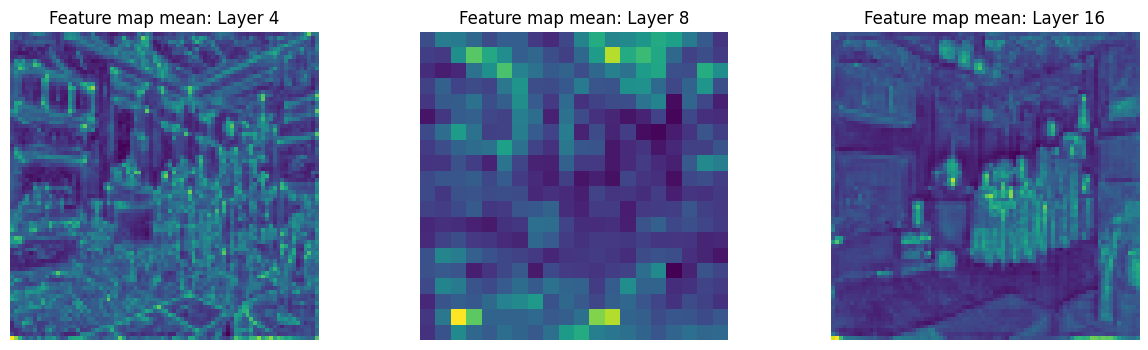

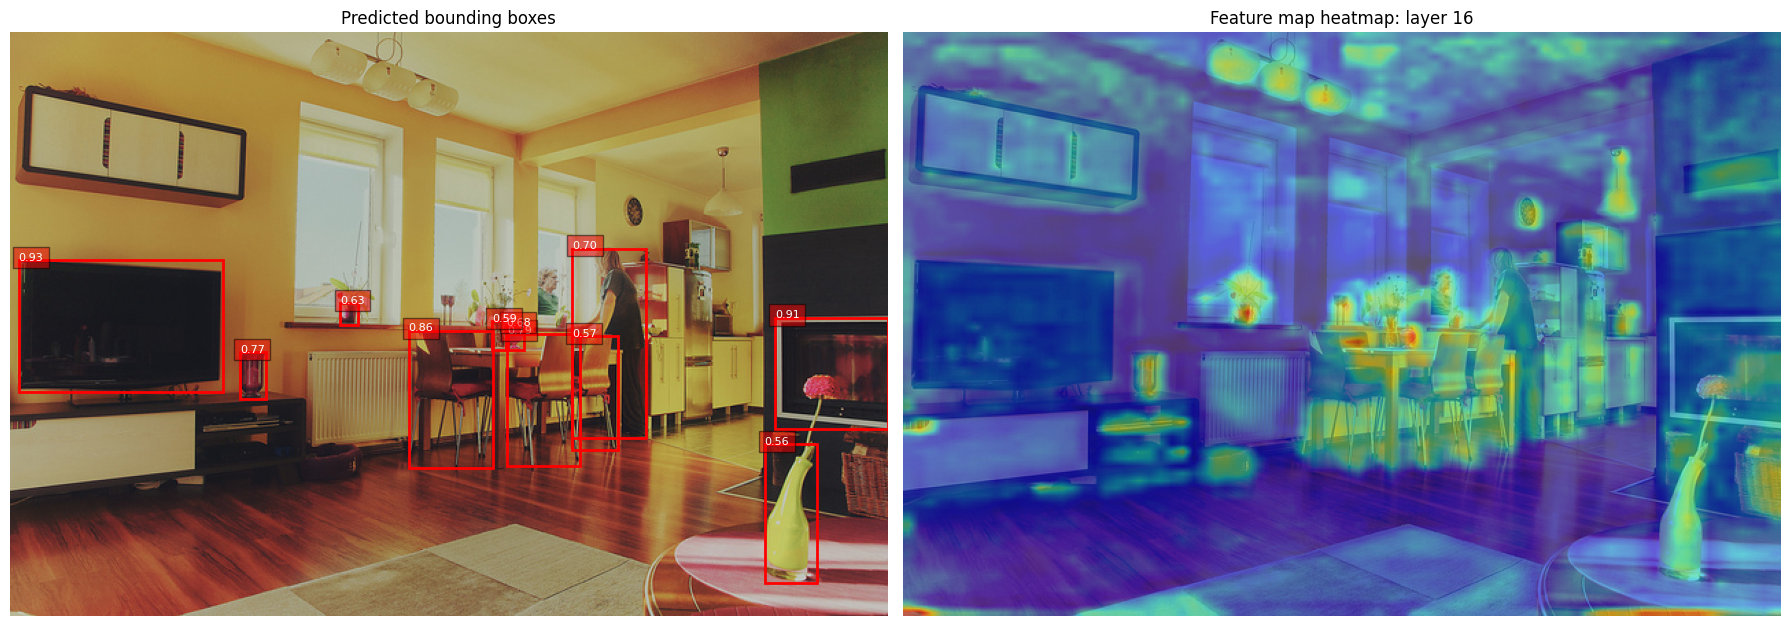

In [54]:
img_path = '/kaggle/input/coco-2017-dataset/coco2017/val2017/000000000139.jpg'
visualize_yolo_feature_maps_and_boxes(
    img_path, model, device, layer_idxs=[4, 8, 16], threshold=0.5
)

In [ ]:
ANNOT_PATH = "/kaggle/working/voc2012_all_as_coco.json"
VAL_IMAGES = "/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages"